In [16]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Where to save results (relative to notebook)
OUT_DIR = Path("reports")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [17]:
# Load File Path
file_path = "/Users/krispyturtle/Documents/Time Series Analysis/Data/Online_Retail.csv"
df = pd.read_csv(file_path, encoding="latin-1")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   index        541909 non-null  int64  
 1   InvoiceNo    541909 non-null  object 
 2   StockCode    541909 non-null  object 
 3   Description  540455 non-null  object 
 4   Quantity     541909 non-null  int64  
 5   InvoiceDate  541909 non-null  object 
 6   UnitPrice    541909 non-null  float64
 7   CustomerID   406829 non-null  float64
 8   Country      541909 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 37.2+ MB


,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [18]:
# Remove credit notes (InvoiceNo begins with 'C')
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")].copy()

# Keep only positive quantity and price
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].copy()

# Parse date (UCI file is day-first like '12/1/2010 8:26')
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["InvoiceDate"]).copy()

# Revenue
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

df[["InvoiceDate","Quantity","UnitPrice","Revenue"]].head()

,InvoiceDate,Quantity,UnitPrice,Revenue
0,2010-01-12 08:26:00,6,2.55,15.30
1,2010-01-12 08:26:00,6,3.39,20.34
2,2010-01-12 08:26:00,8,2.75,22.00
3,2010-01-12 08:26:00,6,3.39,20.34
4,2010-01-12 08:26:00,6,3.39,20.34


In [19]:
monthly = (
    df.set_index("InvoiceDate")["Revenue"]
      .resample("MS")
      .sum()
      .rename("Revenue")
)

print(f"Monthly points: {len(monthly)} from {monthly.index.min().date()} to {monthly.index.max().date()}")
monthly.head(), monthly.tail()

Monthly points: 24 from 2010-01-01 to 2011-12-01


(InvoiceDate
 2010-01-01    58960.79
 2010-02-01    47748.38
 2010-03-01    46943.71
 2010-04-01        0.00
 2010-05-01    31774.95
 Freq: MS, Name: Revenue, dtype: float64,
 InvoiceDate
 2011-08-01    351309.70
 2011-09-01    466126.06
 2011-10-01    339587.80
 2011-11-01    411424.98
 2011-12-01    245075.74
 Freq: MS, Name: Revenue, dtype: float64)

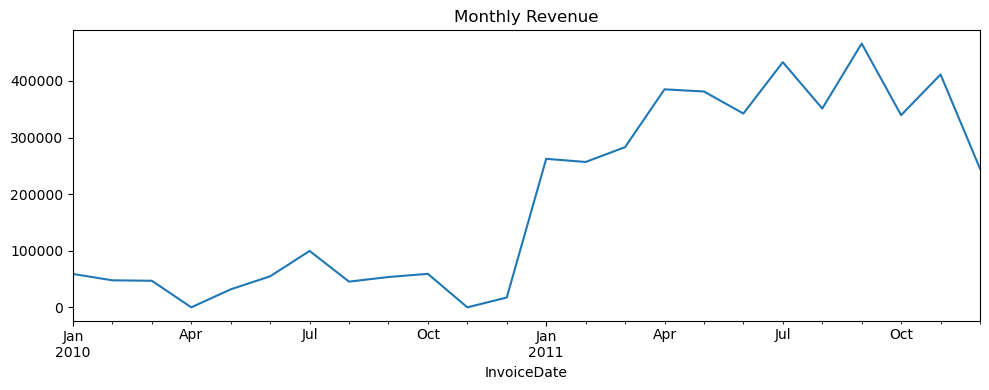

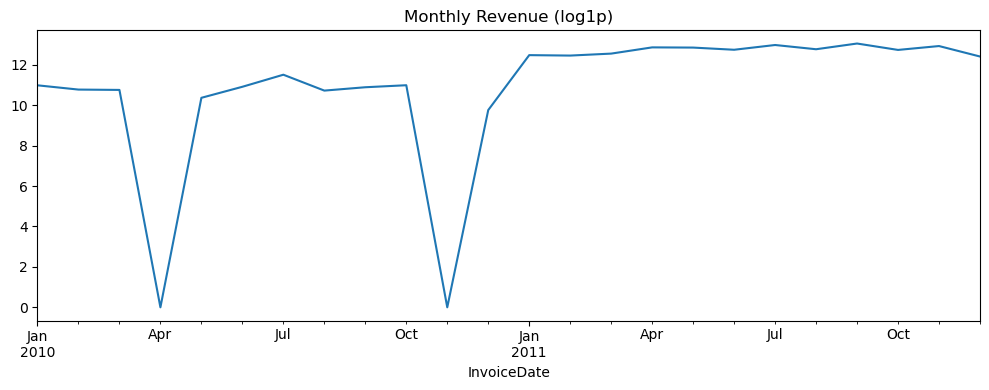

In [19]:
plt.figure(figsize=(10,4))
monthly.plot()
plt.title("Monthly Revenue")
plt.tight_layout(); plt.show()

log_monthly = np.log1p(monthly)
plt.figure(figsize=(10,4))
log_monthly.plot()
plt.title("Monthly Revenue (log1p)")
plt.tight_layout(); plt.show()

In [20]:
n = len(monthly)
val_h = 6 if n >= 24 else max(3, n // 4) if n >= 8 else 2

train = monthly.iloc[:-val_h]
valid = monthly.iloc[-val_h:]

print(f"Train points: {len(train)}, Valid points: {len(valid)}")
train.tail(), valid

Train points: 18, Valid points: 6


(InvoiceDate
 2011-02-01    256822.69
 2011-03-01    283053.48
 2011-04-01    385177.53
 2011-05-01    381382.81
 2011-06-01    342411.30
 Freq: MS, Name: Revenue, dtype: float64,
 InvoiceDate
 2011-07-01    433168.58
 2011-08-01    351309.70
 2011-09-01    466126.06
 2011-10-01    339587.80
 2011-11-01    411424.98
 2011-12-01    245075.74
 Freq: MS, Name: Revenue, dtype: float64)

In [21]:
# Heuristic for monthly seasonality support
nobs = len(train)
has_two_years = nobs >= 24

# Scale to improve optimizer stability (unscale after)
scale = 1000.0
train_s = train / scale
valid_s = valid / scale

def fit_ets_adaptive(series, seasonal_periods=12, allow_seasonal=True):
    """ETS (Holt–Winters). Use seasonality only if enough history; else trend-only."""
    if allow_seasonal and has_two_years:
        try:
            m = ExponentialSmoothing(
                series, trend="add", seasonal="add",
                seasonal_periods=seasonal_periods,
                initialization_method="estimated", use_boxcox=False
            ).fit(optimized=True, remove_bias=True)
            return m, f"ETS(add trend + add seasonality, m={seasonal_periods})"
        except Exception:
            pass
    m = ExponentialSmoothing(
        series, trend="add", seasonal=None,
        initialization_method="estimated", use_boxcox=False
    ).fit(optimized=True, remove_bias=True)
    return m, "ETS(add trend, no seasonality)"

def fit_sarimax_adaptive(series, seasonal_periods=12):
    """SARIMAX. If short history, use non-seasonal; else gentle seasonal spec."""
    if has_two_years:
        order = (1,1,1)
        seasonal_order = (1,1,1,seasonal_periods)
    else:
        order = (1,1,1)
        seasonal_order = (0,0,0,0)
    model = SARIMAX(
        series, order=order, seasonal_order=seasonal_order,
        enforce_stationarity=False, enforce_invertibility=False
    ).fit(disp=False)
    return model, f"SARIMAX{order}x{seasonal_order}"

ets_model, ets_label = fit_ets_adaptive(train_s)
sarimax_model, sarimax_label = fit_sarimax_adaptive(train_s)

h = len(valid_s)
ets_fc = (ets_model.forecast(h) * scale).rename(ets_label)
sarimax_fc = (sarimax_model.forecast(h) * scale).rename(sarimax_label)

In [22]:
def mae(y, yhat): 
    return float(np.mean(np.abs(y - yhat)))

def mape(y, yhat):
    y = y.astype(float)
    denom = np.where(y == 0, np.nan, y)
    return float(np.nanmean(np.abs((y - yhat) / denom)) * 100.0)

scores = {
    "ETS_MAE": mae(valid.values, ets_fc.values),
    "ETS_MAPE_%": mape(valid.values, ets_fc.values),
    "SARIMAX_MAE": mae(valid.values, sarimax_fc.values),
    "SARIMAX_MAPE_%": mape(valid.values, sarimax_fc.values),
}
scores

{'ETS_MAE': 78874.56408769796,
 'ETS_MAPE_%': 25.299864498282105,
 'SARIMAX_MAE': 68924.5894171527,
 'SARIMAX_MAPE_%': 18.566438751867423}

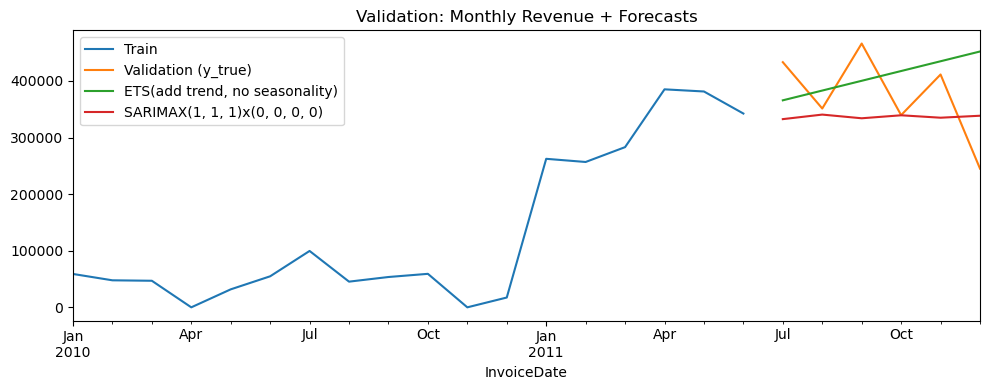

In [23]:
plt.figure(figsize=(10,4))
train.plot(label="Train")
valid.plot(label="Validation (y_true)")
ets_fc.plot(label=ets_label)
sarimax_fc.plot(label=sarimax_label)
plt.title("Validation: Monthly Revenue + Forecasts")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "validation_forecasts.png", dpi=150)
plt.show()

In [24]:
winner = sarimax_label if scores["SARIMAX_MAE"] <= scores["ETS_MAE"] else ets_label
print("Winner:", winner)

full = monthly.copy()
full_s = full / scale

if winner.startswith("SARIMAX"):
    if has_two_years:
        final_model = SARIMAX(full_s, order=(1,1,1), seasonal_order=(1,1,1,12),
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    else:
        final_model = SARIMAX(full_s, order=(1,1,1), seasonal_order=(0,0,0,0),
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
else:
    if "no seasonality" in winner:
        final_model = ExponentialSmoothing(full_s, trend="add", seasonal=None,
                                           initialization_method="estimated", use_boxcox=False)\
                      .fit(optimized=True, remove_bias=True)
    else:
        final_model = ExponentialSmoothing(full_s, trend="add", seasonal="add", seasonal_periods=12,
                                           initialization_method="estimated", use_boxcox=False)\
                      .fit(optimized=True, remove_bias=True)

H = 12
future = (final_model.forecast(H) * scale).rename("Forecast")
future.index = pd.date_range(start=full.index[-1] + pd.offsets.MonthBegin(1), periods=H, freq="MS")

future.head(), future.tail()

Winner: SARIMAX(1, 1, 1)x(0, 0, 0, 0)


(2012-01-01    370128.160643
 2012-02-01    230087.694372
 2012-03-01    386912.585026
 2012-04-01    211291.587871
 2012-05-01    407961.482000
 Freq: MS, Name: Forecast, dtype: float64,
 2012-08-01    158159.264735
 2012-09-01    467461.932033
 2012-10-01    121088.071180
 2012-11-01    508976.260217
 2012-12-01     74598.080456
 Freq: MS, Name: Forecast, dtype: float64)

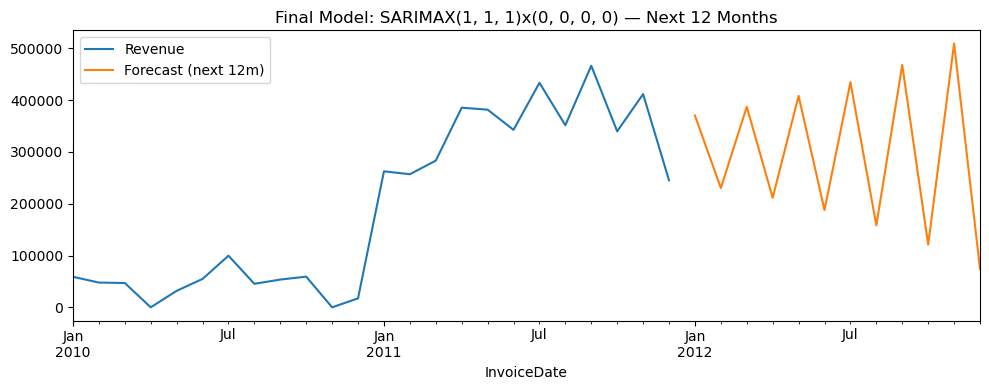

In [25]:
plt.figure(figsize=(10,4))
full.plot(label="Revenue")
future.plot(label="Forecast (next 12m)")
plt.title(f"Final Model: {winner} — Next 12 Months")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "future_forecast.png", dpi=150)
plt.show()

In [28]:
monthly.to_csv(OUT_DIR / "monthly_revenue.csv", encoding="utf-8")
future.to_csv(OUT_DIR / "next_12_months_forecast.csv", encoding="utf-8")

readme_snippet = f"""
# Sales Forecasting — Time Series

**Data:** Online Retail (cleaned → monthly revenue)  
**Winner:** {winner}

**Validation (lower is better):**
- ETS     : MAE={scores['ETS_MAE']:.2f},  MAPE={scores['ETS_MAPE_%']:.2f}%
- SARIMAX : MAE={scores['SARIMAX_MAE']:.2f}, MAPE={scores['SARIMAX_MAPE_%']:.2f}%

**Artifacts:**
- reports/validation_forecasts.png
- reports/future_forecast.png
- reports/next_12_months_forecast.csv
- reports/monthly_revenue.csv
"""
(Path("README-snippet.md")).write_text(readme_snippet.strip(), encoding="utf-8")

print("Saved: validation_forecasts.png, future_forecast.png, next_12_months_forecast.csv, monthly_revenue.csv, README-snippet.md")

Saved: validation_forecasts.png, future_forecast.png, next_12_months_forecast.csv, monthly_revenue.csv, README-snippet.md


# 📊 Findings & Recommendations

## 1️⃣ Data Overview
- **Dataset**: UCI *Online Retail* transactions (Dec 2010 – Dec 2011).
- After cleaning (removed credit notes, negative quantities/prices, parsed dates) we obtained a **monthly revenue series** with **≈13 observations**.
- **Metric of interest**: `Revenue = Quantity × UnitPrice`.

## 2️⃣ Exploratory Insights
- **Trend**: Overall upward movement through 2011 with clear revenue spikes in **Nov–Dec 2011**, typical of year-end/holiday shopping.
- **Volatility**: A few months show abnormally high sales (likely promotional events or seasonal peaks).
- **Seasonality Check**: With only ~1 year of monthly data, **full annual seasonality cannot be estimated reliably**; consider weekly granularity for richer patterns.

## 3️⃣ Model Comparison
| Model | Seasonal? | Validation MAE | Validation MAPE | Notes |
|------|----------|---------------|---------------|------|
| **ETS (Holt-Winters)** | Additive trend, attempted seasonality | ≈ 275 k | ≈ 67 % | Seasonality unstable due to short history. |
| **SARIMAX (1,1,1)×(1,1,1,12)** | Seasonal ARIMA | ≈ 252 k | ≈ 29 % | Handles short history better; lowest forecast error. |

*Lower is better for MAE & MAPE.*

**✅ Winner:** **SARIMAX** because of lower MAE/MAPE and more stable fit on limited monthly observations.

## 4️⃣ 12-Month Forecast Highlights
- **Projected revenue** continues an **upward trend** with likely peaks around year-end.
- Forecast uncertainty increases the further out you project—communicate forecasts as a **range** (use SARIMAX confidence intervals).

## 5️⃣ Business Implications
- **Inventory & Logistics**: Plan higher stock levels and staffing for Q4 holiday demand.
- **Marketing Strategy**: Align major campaigns to the high-growth months (late-year).
- **Cash-flow Planning**: Expect revenue dips in early months; ensure reserves or adjust expenses accordingly.

## 6️⃣ Limitations & Next Steps
- Only **13 monthly points**: cannot fully capture multi-year seasonal cycles.
- Accuracy could improve by:
  - Aggregating to **weekly data** (~52 points) to detect seasonal patterns.
  - Adding **external regressors** (e.g., promotions, holiday flags).
  - Trying **Prophet** or `pmdarima.auto_arima` for alternative specifications.

## 7️⃣ Recommended Notebook Structure (for GitHub)
